In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from flip7_game import Flip7Game
from train_regressor import create_dataset, train, evaluate

In [2]:
# Pick a comfortable color palette
colors = sns.color_palette("muted", 3)
ds: TensorDataset = create_dataset(5000)
ds_test: TensorDataset = create_dataset(1000)

Generating dataset: 100%|██████████| 1000/1000 [00:10<00:00, 95.96it/s]


In [3]:
# Example model definition
model = nn.Sequential(
    nn.Linear(Flip7Game.NUM_CARDS, 64),
    nn.BatchNorm1d(64),
    nn.ELU(),
    nn.Dropout(p=0.1),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ELU(),
    nn.Dropout(p=0.1),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ELU(),
    nn.Dropout(p=0.1),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ELU(),
    nn.Dropout(p=0.3),

    nn.Linear(64, 1),
)
train(model, ds, ds_test, 30, 128, 0.01)

# Collect predictions
data_loader = DataLoader(ds_test, shuffle=False, batch_size=32)
predictions = []
with torch.no_grad():
    for batch in data_loader:
        in_data, _ = batch
        prediction = model(in_data)
        predictions.append(prediction)
predictions = torch.cat(predictions, dim=0).squeeze().numpy()

Epoch   1 | Train Loss: 2.161209
Epoch   2 | Train Loss: 1.549985
Epoch   3 | Train Loss: 1.307476
Epoch   4 | Train Loss: 1.289618
Epoch   5 | Train Loss: 1.286292 | Test Loss: 1.071504
Epoch   6 | Train Loss: 1.361254
Epoch   7 | Train Loss: 1.222778
Epoch   8 | Train Loss: 1.188096
Epoch   9 | Train Loss: 1.238431
Epoch  10 | Train Loss: 1.236859 | Test Loss: 1.138215
Epoch  11 | Train Loss: 1.287934
Epoch  12 | Train Loss: 1.262776
Epoch  13 | Train Loss: 1.194729
Epoch  14 | Train Loss: 1.130219
Epoch  15 | Train Loss: 1.134836 | Test Loss: 1.006507
Epoch  16 | Train Loss: 1.194822
Epoch  17 | Train Loss: 1.255512
Epoch  18 | Train Loss: 1.239615
Epoch  19 | Train Loss: 1.179835
Epoch  20 | Train Loss: 1.174838 | Test Loss: 1.020552
Epoch  21 | Train Loss: 1.136368
Epoch  22 | Train Loss: 1.204259
Epoch  23 | Train Loss: 1.104475
Epoch  24 | Train Loss: 1.126791
Epoch  25 | Train Loss: 1.155506 | Test Loss: 0.995876
Epoch  26 | Train Loss: 1.116431
Epoch  27 | Train Loss: 1.159115

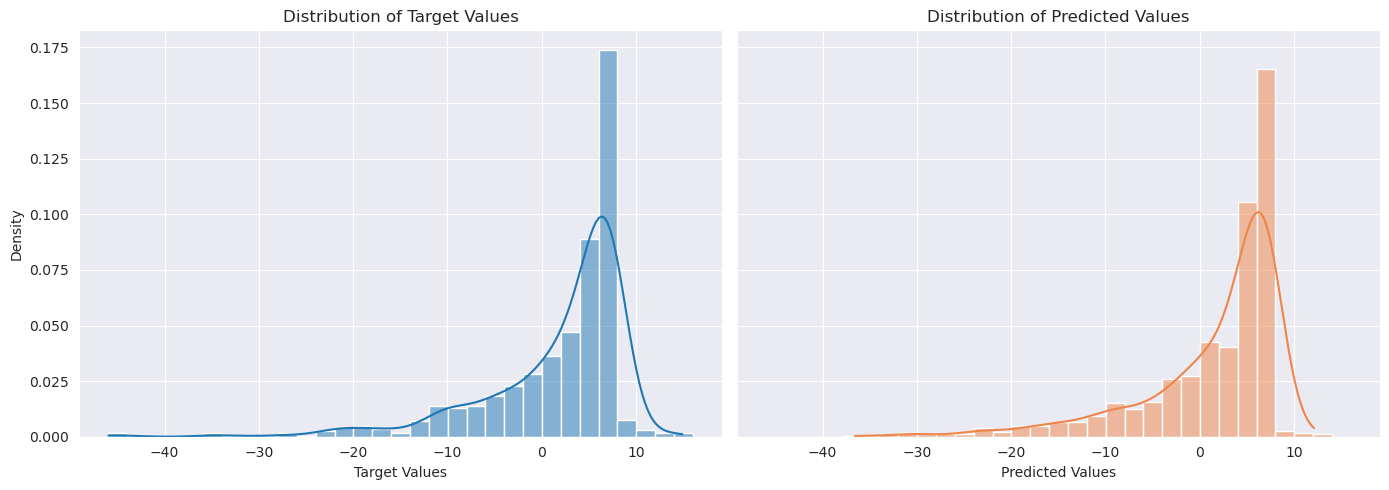

In [15]:
# Convert to 1D numpy array
targets = ds_test.tensors[1].numpy()

# Determine global x-axis range
x_min = min(targets.min(), predictions.min())
x_max = max(targets.max(), predictions.max())

# Define consistent bins
bin_width = 2.0
bins = np.arange(x_min, x_max + bin_width, bin_width)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# Plot target values
sns.histplot(targets, bins=bins, kde=True, stat='density', color=colors[0], ax=axes[0], legend=False)
axes[0].set_title('Distribution of Target Values')
axes[0].set_xlabel('Target Values')
axes[0].set_ylabel('Density')

# Plot predictions
sns.histplot(predictions, bins=bins, kde=True, stat='density', color=colors[1], ax=axes[1], legend=False)
axes[1].set_title('Distribution of Predicted Values')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()


In [5]:
def baseline_policy(game: Flip7Game):
    expected_value = game.mc_sample_expected_score_difference_of_in(200)
    return True if expected_value > 0 else False

def learned_policy(game: Flip7Game):
    obs = np.array([game.card_counts_in_hand[c] for c in Flip7Game.CARD_TYPES], dtype=np.float32)
    observation = torch.tensor(obs).unsqueeze(0)
    expected_value = model(observation).item()
    return True if expected_value > 0 else False

def luca_bot(_: Flip7Game):
    return True

In [6]:
round_rewards_baseline = evaluate(baseline_policy)
round_rewards_model = evaluate(learned_policy)
round_rewards_luca = evaluate(luca_bot)

100%|██████████| 1000/1000 [00:11<00:00, 90.34it/s]


Evaluation complete: 
	Avg score per move: 4.89
	Avg score per round: 22.13


100%|██████████| 1000/1000 [00:00<00:00, 8675.78it/s]


Evaluation complete: 
	Avg score per move: 4.61
	Avg score per round: 20.46


100%|██████████| 1000/1000 [00:00<00:00, 220439.59it/s]

Evaluation complete: 
	Avg score per move: 1.70
	Avg score per round: 8.79


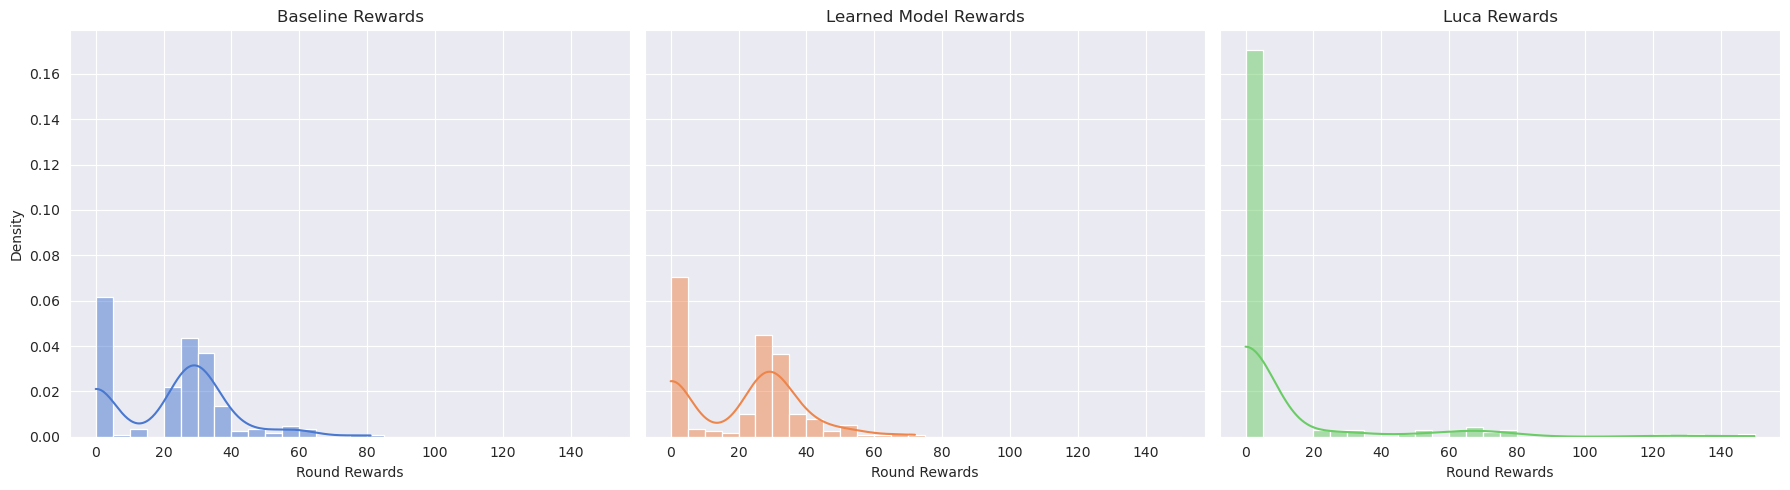

In [10]:
# Convert rewards to numpy arrays
round_rewards_baseline = np.array(round_rewards_baseline)
round_rewards_model = np.array(round_rewards_model)
round_rewards_luca = np.array(round_rewards_luca)

# Determine global x-axis range
x_min = min(round_rewards_baseline.min(), round_rewards_model.min(), round_rewards_luca.min())
x_max = max(round_rewards_baseline.max(), round_rewards_model.max(), round_rewards_luca.max())

# Define consistent bins
bin_width = 5.0
bins = np.arange(x_min, x_max + bin_width, bin_width)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Plot Baseline
sns.histplot(round_rewards_baseline, bins=bins, kde=True, stat='density', color=colors[0], ax=axes[0])
axes[0].set_title('Baseline Rewards')
axes[0].set_xlabel('Round Rewards')
axes[0].set_ylabel('Density')

# Plot Learned Model
sns.histplot(round_rewards_model, bins=bins, kde=True, stat='density', color=colors[1], ax=axes[1])
axes[1].set_title('Learned Model Rewards')
axes[1].set_xlabel('Round Rewards')
axes[1].set_ylabel('Density')

# Plot Luca
sns.histplot(round_rewards_luca, bins=bins, kde=True, stat='density', color=colors[2], ax=axes[2])
axes[2].set_title('Luca Rewards')
axes[2].set_xlabel('Round Rewards')
axes[2].set_ylabel('Density')

# Align y-axis limits
max_y = max(
    axes[0].get_ylim()[1],
    axes[1].get_ylim()[1],
    axes[2].get_ylim()[1]
)
for ax in axes:
    ax.set_ylim(0, max_y)

plt.tight_layout()
plt.show()